# K-Means Iris dataset

In [8]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import mode
import numpy as np
from sklearn.metrics import silhouette_score



In [9]:
RANDOM_SEED = 9
DATASPLIT = 0.3
DATASET_ID= 17

In [10]:
logger = logging.getLogger(str(DATASET_ID))
logging.basicConfig(level=logging.DEBUG)

In [11]:
dataset = fetch_ucirepo(id=DATASET_ID)

df = pd.DataFrame(dataset.data.features)

label_encoder = LabelEncoder()

df['class'] = label_encoder.fit_transform(dataset.data.targets)

df = df.replace("?", pd.NA).dropna()

scaler = StandardScaler()

data = scaler.fit_transform(df)

labels = df['class']

df = df.drop(columns=['class'])



data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=DATASPLIT, random_state=RANDOM_SEED)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=DATASPLIT, random_state=RANDOM_SEED)

logger.info(f"Train dataset length: {len(data_train)}, Validation dataset length: {len(data_val)}, Test dataset length: {len(data_test)}")

print(df.head())




/home/hedlund01/SynologyDrive/LTU/D7041E/Miniproject/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:17:Train dataset length: 278, Validation dataset length: 120, Test dataset length: 171


   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

In [12]:
parameters = {
    'n_clusters': range(2, 10, 1),
    'max_iter': range(100, 500, 100),
}


clf = GridSearchCV(KMeans(random_state=RANDOM_SEED), parameters, scoring='accuracy', verbose=0)
clf.fit(data_val, label_val)

model = clf.best_estimator_
logger.info("Best cross-validation score: %f", clf.best_score_)
logger.info("With parameters: %s", clf.best_params_)

logger.info("Training model with best parameters")
model.fit(data_train, label_train)

predictions = model.predict(data_test)

   
mapped_labels = np.zeros_like(predictions)
for i in range(clf.best_params_['n_clusters']):  
    mask = (predictions == i)
    mapped_labels[mask] = mode(label_test[mask])[0]



accuracy = accuracy_score(label_test, mapped_labels)
logger.info("Accuracy: %f", accuracy)

f1 = f1_score(label_test, mapped_labels, average='weighted')
logger.info("F1 score: %f", f1)

ari = adjusted_rand_score(label_test, mapped_labels)
logger.info("ARI score: %f", ari)

sil = silhouette_score(data_test, mapped_labels)
logger.info("Silhouette score: %f", sil)


INFO:17:Best cross-validation score: 0.700000
INFO:17:With parameters: {'max_iter': 100, 'n_clusters': 2}
INFO:17:Training model with best parameters
INFO:17:Accuracy: 0.935673
INFO:17:F1 score: 0.935312
INFO:17:ARI score: 0.756275
INFO:17:Silhouette score: 0.359782


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ed0cff0dc70>


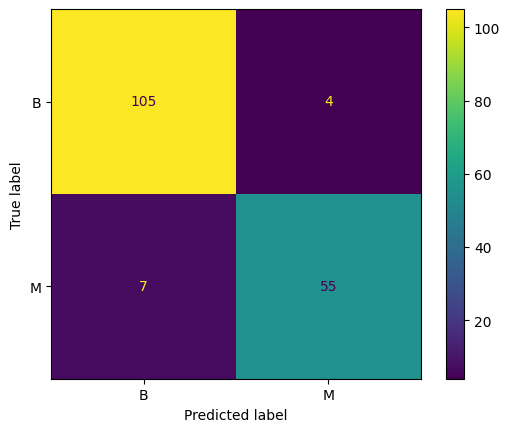

In [13]:
cm = confusion_matrix(label_test, mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


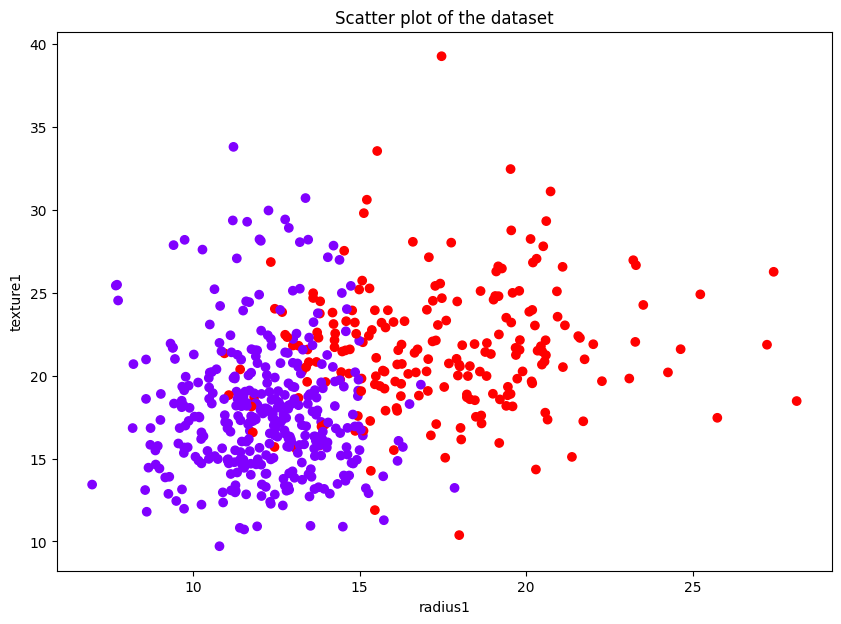

In [14]:

plt.figure(figsize=(10, 7))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, cmap='rainbow')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Scatter plot of the dataset")
plt.show()